In [ ]:
!pip install transformers scikit-learn

In [ ]:
import pandas as pd
import numpy as np
import torch
import tensorflow as tf
import re
import os
import pickle
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, f1_score
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Centralizando os hiperparâmetros
MAX_LEN = 512
BATCH_SIZE = 32 # Lote para extração
EMBEDDING_DIM = 768

In [ ]:
# Arquivos do projeto
EMBEDDINGS_FILE = "bert_embeddings.dat"
CLASSIFIER_MODEL = "bilstm_classifier.keras"
TOKENIZER_PATH = "distilbert_tokenizer"
MODEL_CONFIG_FILE = "model_metadata.pkl"

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
df = pd.read_csv("train.csv")

### **Pré-processamento**

In [ ]:
df = df.drop(columns=["subject", "date"], errors="ignore")

def clean_text_light(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(r"\(?reuters\)?\s*-?", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["text_light"] = (df["title"] + " " + df["text"]).apply(clean_text_light)

X_text = df["text_light"].values
y = df["label"].values
N_SAMPLES = len(X_text)
# Remove Link, veículo de notícias, múltiplos espaços

### **Extranindo Embbedings: BERT e MEMMAP**

In [ ]:
# Carrega tokenizer e modelo DistilBERT pré-treinado
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
bert_model = DistilBertModel.from_pretrained("distilbert-base-uncased").to(device)
bert_model.eval()  # Modo avaliação (desativa dropout)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertModel LOAD REPORT from: distilbert-base-uncased
Key                     | Status     |  | 
------------------------+------------+--+-
vocab_layer_norm.weight | UNEXPECTED |  | 
vocab_transform.bias    | UNEXPECTED |  | 
vocab_transform.weight  | UNEXPECTED |  | 
vocab_projector.bias    | UNEXPECTED |  | 
vocab_layer_norm.bias   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSelfAttention(
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

In [ ]:
# Se já existe arquivo antigo de embeddings, remove
if os.path.exists(EMBEDDINGS_FILE):
    os.remove(EMBEDDINGS_FILE)

In [ ]:
# Aloca espaço no disco
X_memmap = np.memmap(
    EMBEDDINGS_FILE,
    dtype="float32",
    mode="w+",
    shape=(N_SAMPLES, MAX_LEN, EMBEDDING_DIM)
)

In [ ]:
# Trunca texto: pega 382 do começo e 128 do final se passar de 512 tokens
def smart_truncate(text, tokenizer, max_len=512):
    limit = max_len - 2
    tokens = tokenizer.encode(text, add_special_tokens=False)
    if len(tokens) <= limit:
        return tokenizer.encode(text, max_length=max_len, padding="max_length", truncation=True)
    head = tokens[:382]
    tail = tokens[-128:]
    return [tokenizer.cls_token_id] + head + tail + [tokenizer.sep_token_id]

In [ ]:
for i in tqdm(range(0, N_SAMPLES, BATCH_SIZE)):
    batch_texts = X_text[i : i + BATCH_SIZE]

    input_ids = []
    attention_masks = []

    for text in batch_texts:
        ids = smart_truncate(text, tokenizer, MAX_LEN)
        # Pad manual
        if len(ids) < MAX_LEN:
            ids = ids + [tokenizer.pad_token_id] * (MAX_LEN - len(ids))

        mask = [1 if token != tokenizer.pad_token_id else 0 for token in ids]
        input_ids.append(ids)
        attention_masks.append(mask)

    input_ids_pt = torch.tensor(input_ids).to(device)
    attention_masks_pt = torch.tensor(attention_masks).to(device)

    with torch.no_grad():
        outputs = bert_model(input_ids_pt, attention_mask=attention_masks_pt)
        batch_embeddings = outputs.last_hidden_state

        # Aplica a máscara para zerar padding
        mask_expanded = attention_masks_pt.unsqueeze(-1).expand(batch_embeddings.size()).float()
        batch_embeddings = batch_embeddings * mask_expanded

        # Escreve no Memmap (Disco)
        # O .cpu().numpy() tira da GPU e joga pro disco via memmap
        X_memmap[i : i + len(batch_texts)] = batch_embeddings.cpu().numpy()

        # Força gravação no disco para liberar RAM
        X_memmap.flush()

# Limpa GPU
del bert_model
torch.cuda.empty_cache()

100%|██████████| 714/714 [10:07<00:00,  1.18it/s]


### **Gerador e Split**

In [ ]:
class MemmapGenerator(tf.keras.utils.Sequence):

    def __init__(self, memmap_data, indices, labels, batch_size=16):
        self.memmap_data = memmap_data
        self.indices = indices
        self.labels = labels
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        X_batch = self.memmap_data[batch_indices]
        y_batch = self.labels[batch_indices]
        return X_batch, y_batch


indices = np.arange(N_SAMPLES)

In [ ]:
train_idx, val_idx, y_train_split, y_val_split = train_test_split(
    indices, y, test_size=0.2, stratify=y, random_state=42
)

weights = class_weight.compute_class_weight(
    "balanced",
    classes=np.unique(y_train_split),
    y=y_train_split
)

class_weights = dict(zip(np.unique(y_train_split), weights))

X_memmap_read = np.memmap(
    EMBEDDINGS_FILE,
    dtype="float32",
    mode="r",
    shape=(N_SAMPLES, MAX_LEN, EMBEDDING_DIM)
)

train_gen = MemmapGenerator(X_memmap_read, train_idx, y, batch_size=16)
val_gen = MemmapGenerator(X_memmap_read, val_idx, y, batch_size=16)

### **Treinamento**

In [ ]:
def build_lstm_classifier():

    # Modelo recebe embeddings do BERT (MAX_LEN x 768) e usa BiLSTM para capturar contexto
    inputs = tf.keras.Input(shape=(MAX_LEN, EMBEDDING_DIM))
    x = tf.keras.layers.Masking(mask_value=0.0)(inputs)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128))(x)
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model


model = build_lstm_classifier()

# Callbacks para salvar melhor modelo e parar treino se não melhorar
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "best_lstm.keras",
    monitor="val_loss",
    save_best_only=True
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

# Treina o classificador usando embeddings pré-gerados
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    class_weight=class_weights,
    callbacks=[checkpoint, early_stop]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1143/1143 ━━━━━━━━━━━━━━━━━━━━ 196s 167ms/step - accuracy: 0.9763 - loss: 0.0679 - val_accuracy: 0.9996 - val_loss: 0.0017
Epoch 2/10
1143/1143 ━━━━━━━━━━━━━━━━━━━━ 187s 164ms/step - accuracy: 0.9991 - loss: 0.0029 - val_accuracy: 0.9947 - val_loss: 0.0163
Epoch 3/10
1143/1143 ━━━━━━━━━━━━━━━━━━━━ 188s 164ms/step - accuracy: 0.9988 - loss: 0.0032 - val_accuracy: 0.9996 - val_loss: 0.0011
Epoch 4/10
1143/1143 ━━━━━━━━━━━━━━━━━━━━ 195s 170ms/step - accuracy: 0.9999 - loss: 3.5710e-04 - val_accuracy: 0.9996 - val_loss: 0.0023
Epoch 5/10
1143/1143 ━━━━━━━━━━━━━━━━━━━━ 185s 162ms/step - accuracy: 0.9999 - loss: 7.6754e-04 - val_accuracy: 0.9996 - val_loss: 0.0023
Epoch 6/10
1143/1143 ━━━━━━━━━━━━━━━━━━━━ 184s 161ms/step - accuracy: 1.0000 - loss: 1.1747e-05 - val_accuracy: 0.9996 - val_loss: 0.0026


### **Avaliação e Limite**

In [ ]:
y_pred_prob = model.predict(val_gen)
y_true_val = y[val_idx]

thresholds = np.arange(0.1, 0.9, 0.01)

f1_scores = [
    f1_score(y_true_val, (y_pred_prob > t).astype(int))
    for t in thresholds
]

best_thresh = thresholds[np.argmax(f1_scores)]

print("Melhor Threshold:", best_thresh)
print("Melhor F1:", max(f1_scores))
print(classification_report(
    y_true_val,
    (y_pred_prob > best_thresh).astype(int),
    digits=4
))

286/286 ━━━━━━━━━━━━━━━━━━━━ 37s 128ms/step
Melhor Threshold: 0.1
Melhor F1: 0.9991251093613298
              precision    recall  f1-score   support

           0     1.0000    0.9994    0.9997      3427
           1     0.9983    1.0000    0.9991      1142

    accuracy                         0.9996      4569
   macro avg     0.9991    0.9997    0.9994      4569
weighted avg     0.9996    0.9996    0.9996      4569



### **Salvar**

In [ ]:
model.save(CLASSIFIER_MODEL)

tokenizer.save_pretrained(TOKENIZER_PATH)

configuracoes = {
    "best_threshold": best_thresh,
    "max_len": MAX_LEN
}

with open(MODEL_CONFIG_FILE, "wb") as f:
    pickle.dump(configuracoes, f)

### **Interpretação das Métricas**

MCC: 0.9988339039679498


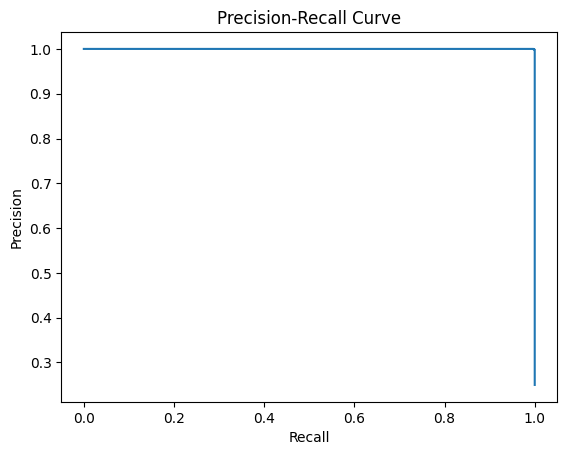

In [ ]:
from sklearn.metrics import matthews_corrcoef, precision_recall_curve

y_pred_final = (y_pred_prob > best_thresh).astype(int)
mcc = matthews_corrcoef(y_true_val, y_pred_final)
print("MCC:", mcc)

precision, recall, _ = precision_recall_curve(y_true_val, y_pred_prob)

plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

def analyze_sensitivity(sample_index, remove_tokens=50):
    original_embedding = X_memmap_read[sample_index:sample_index+1]
    original_prob = model.predict(original_embedding)[0][0]

    perturbed_embedding = original_embedding.copy()
    perturbed_embedding[:, :remove_tokens, :] = 0

    new_prob = model.predict(perturbed_embedding)[0][0]

    print("Prob original:", float(original_prob))
    print("Prob perturbado:", float(new_prob))
    print("Variação:", abs(float(original_prob - new_prob)))

### **Pipeline para novo conjunto teste**


---




In [ ]:
with open(MODEL_CONFIG_FILE, "rb") as f:
    configuracoes = pickle.load(f)

best_thresh = configuracoes["best_threshold"]
MAX_LEN = configuracoes["max_len"]

tokenizer = DistilBertTokenizer.from_pretrained(TOKENIZER_PATH)
model = tf.keras.models.load_model(CLASSIFIER_MODEL)

bert_model = DistilBertModel.from_pretrained("distilbert-base-uncased").to(device)
bert_model.eval()

df_test = pd.read_csv("test.csv")
df_test["title"] = df_test["title"].fillna("")
df_test["text"] = df_test["text"].fillna("")

df_test["text_light"] = (df_test["title"] + " " + df_test["text"]).apply(clean_text_light)
X_test_text = df_test["text_light"].values

todas_probabilidades = []

for i in tqdm(range(0, len(X_test_text), BATCH_SIZE)):
    batch_texts = X_test_text[i:i+BATCH_SIZE]

    input_ids, attention_masks = [], []

    for text in batch_texts:
        ids = smart_truncate(text, tokenizer, MAX_LEN)

        if len(ids) < MAX_LEN:
            ids += [tokenizer.pad_token_id] * (MAX_LEN - len(ids))

        mask = [1 if token != tokenizer.pad_token_id else 0 for token in ids]

        input_ids.append(ids)
        attention_masks.append(mask)

    input_ids_pt = torch.tensor(input_ids).to(device)
    attention_masks_pt = torch.tensor(attention_masks).to(device)

    with torch.no_grad():
        outputs = bert_model(input_ids_pt, attention_mask=attention_masks_pt)
        embeddings = outputs.last_hidden_state
        mask_expanded = attention_masks_pt.unsqueeze(-1).expand(embeddings.size()).float()
        embeddings = embeddings * mask_expanded

    preds = model.predict(embeddings.cpu().numpy(), verbose=0)
    todas_probabilidades.extend(preds.flatten())

y_pred_test = (np.array(todas_probabilidades) > best_thresh).astype(int)

submission = pd.DataFrame({
    "id": df_test["id"],
    "label": y_pred_test
})

submission.to_csv("submission.csv", index=False)

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertModel LOAD REPORT from: distilbert-base-uncased
Key                     | Status     |  | 
------------------------+------------+--+-
vocab_layer_norm.weight | UNEXPECTED |  | 
vocab_transform.bias    | UNEXPECTED |  | 
vocab_transform.weight  | UNEXPECTED |  | 
vocab_projector.bias    | UNEXPECTED |  | 
vocab_layer_norm.bias   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
100%|██████████| 179/179 [02:35<00:00,  1.15it/s]
